## Regression Model Project

The goal for this project is to build and train a regression model on the Capital Bike Share (Washington, D.C.) Kaggle data set, in order to predict demand for bicycle rentals at any given hour, based on time and weather

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import (PolynomialFeatures, OneHotEncoder, StandardScaler, KBinsDiscretizer)
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.metrics import mean_squared_error,mean_squared_log_error, r2_score

# Importing our dataset 

In [2]:
bike_df = pd.read_csv('/home/evangelo/decision-dill-student-code/week03/data/train.csv')

In [3]:
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# Transform and analyze our data

In [4]:
bike_df['datetime']=pd.to_datetime(bike_df['datetime'])

In [5]:
bike_df['year'] = bike_df['datetime'].dt.year
bike_df['month'] = bike_df['datetime'].dt.month
bike_df['day'] = bike_df['datetime'].dt.day
bike_df['hour'] = bike_df['datetime'].dt.hour
bike_df['minute'] = bike_df['datetime'].dt.minute

In [6]:
bike_df.drop(columns='datetime', inplace=True)

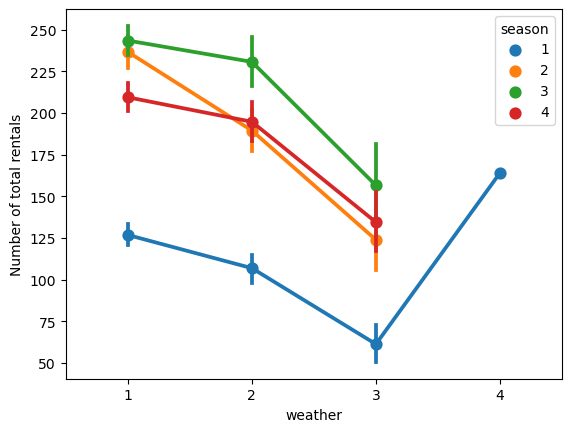

In [7]:
sns.pointplot(data=bike_df, x='weather', y='count', hue='season');
plt.ylabel('Number of total rentals');

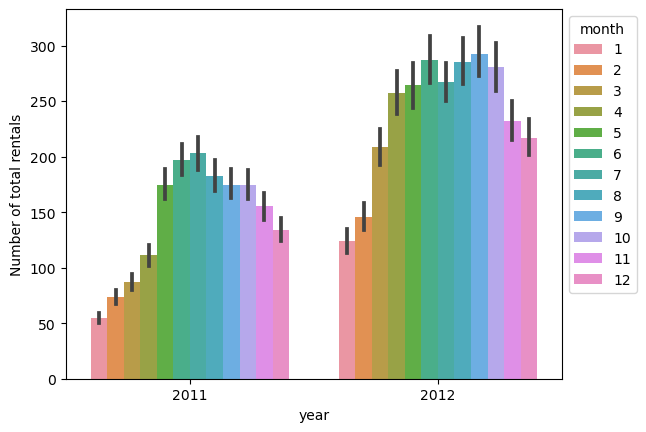

In [8]:
plot = sns.barplot(data=bike_df, x='year', y='count', hue='month');
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel('Number of total rentals');

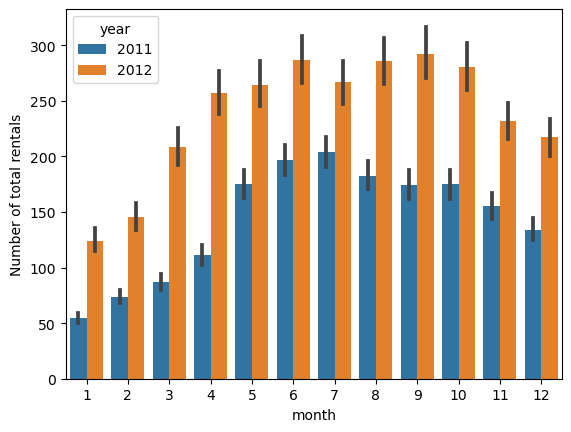

In [9]:
sns.barplot(data=bike_df, x='month', y='count', hue='year');
plt.ylabel('Number of total rentals');

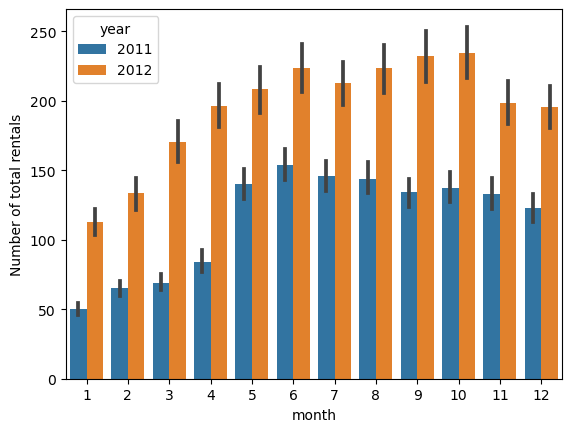

In [10]:
sns.barplot(data=bike_df, x='month', y='registered', hue='year');
plt.ylabel('Number of total rentals');

According to the correlation matrix below, we see that temp and atemp feutures have a very similar correlation with the rest of them and also humidity and windspeed have a bit of change comparing with the other fearues. As a consequence, I chose to subtract some of them to see how my model works

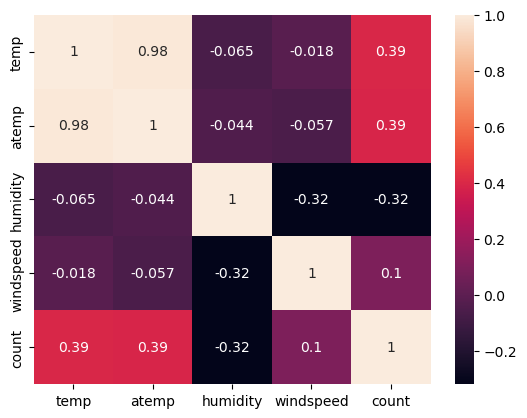

In [12]:
bike_df_heatmap = bike_df[['temp', 'atemp','humidity','windspeed', 'count']]
sns.heatmap(bike_df_heatmap.corr(), annot=True);

In [12]:
y = bike_df['count']
X = bike_df.drop(columns=['casual', 'registered', 'count','humidity', 'atemp', 'windspeed' ])

# Train and test our modelmodel

I wanted to observe the results of different models that's why I checked the Linear Regressor, Poisson, Lasso and Random Forest Regressor 

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lr = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr.fit(X_train, y_train)

print("Coefficients:", lr.coef_)
print("Intercept   :", lr.intercept_)

print("train score :", lr.score(X_train, y_train))
print("test score  :", lr.score(X_test, y_test))

Coefficients: [ -2.8109321  -11.66118296   1.15277374 -28.92373809   6.79826481
  87.11497539   6.16528034   0.32601984   9.50226366   0.        ]
Intercept   : -175283.71908931003
train score : 0.3533335217719762
test score  : 0.3509399956326682


In [15]:
numerical_features = ['temp', 'year', 'month', 'hour']
categorical_features = ['season', 'holiday', 'workingday', 'weather']
#features = numerical_features + categorical_features

# Structure some pipelines

In [58]:
numerical_transform = Pipeline(
    [ ('scale', StandardScaler()),
      ('expand_features', PolynomialFeatures()) ]  )

categorical_transform = Pipeline( [ ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore')) ] )

preprocessor = ColumnTransformer(
    [ ('transform_numeric', numerical_transform, numerical_features,),
      ('transform_categorical', categorical_transform, categorical_features)], 
      remainder='drop' )

pipe_linear = Pipeline(
    [ ('transform_features', preprocessor),
      ('regressor', LinearRegression()) ] )

pipe_linear.fit(X_train, y_train)

print("Coefficients:", pipe_linear[1].coef_)
print("Intercept   :", pipe_linear[1].intercept_)

print("train score :", pipe_linear.score(X_train, y_train))
print("test score  :", pipe_linear.score(X_test, y_test))

Coefficients: [ 0.00000000e+00  5.40786237e+01 -1.06285324e+07  3.08835091e+01
  6.78459219e+01 -2.70033905e+00  7.40412096e+00  9.60189725e+00
  2.58746675e+01 -1.20515065e+09  9.67547464e-01  1.46554450e+01
 -2.30575604e+00  4.63524397e+00 -7.15328873e+01  9.08031298e+00
 -4.54751666e+01 -3.10072369e+00 -9.46024162e+00  2.20095946e+00
 -2.23576709e+01 -7.68753016e+01  1.48521295e+00]
Intercept   : 1205150927.3580742
train score : 0.519919085137434
test score  : 0.5110667193660325


MSE: 15824.153042601763
RMSE: 125.79408985561192
R2: 0.5177077448312775


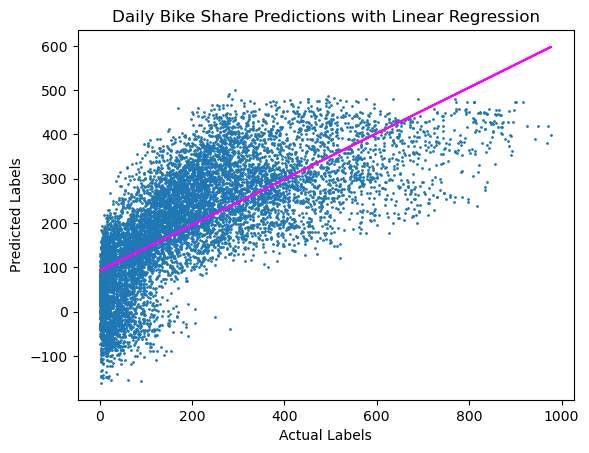

In [63]:
predictions_linear= pipe_linear.predict(X)
mse = mean_squared_error(y, predictions_linear)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y, predictions_linear)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y, predictions_linear, s=1)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions with Linear Regression')
# overlay the regression line
z = np.polyfit(y, predictions_linear, 1)
p = np.poly1d(z)
plt.plot(y,p(y), color='magenta')
plt.show()


In [16]:
numerical_transform = Pipeline(
    [ ('scale', StandardScaler()),
      ('expand_features', PolynomialFeatures()) ]  )

categorical_transform = Pipeline( [ ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore')) ] )

preprocessor = ColumnTransformer(
    [ ('transform_numeric', numerical_transform, numerical_features,),
      ('transform_categorical', categorical_transform, categorical_features)], 
      remainder='drop' )

pipe_poisson = Pipeline(
    [ ('transform_features', preprocessor),
      ('regressor', PoissonRegressor()) ] )

pipe_poisson.fit(X_train, y_train)

print("Coefficients:", pipe_poisson[1].coef_)
print("Intercept   :", pipe_poisson[1].intercept_)

print("train score :", pipe_poisson.score(X_train, y_train))
print("test score  :", pipe_poisson.score(X_test, y_test))

Coefficients: [ 1.63888564e-05  1.27645208e-01  2.52384422e-01  1.44505788e-01
  6.32509489e-01 -7.57230874e-02 -3.63376887e-02 -2.90563635e-02
  1.23224987e-01 -2.20946306e-03 -3.20896277e-02  4.13577498e-03
 -1.27685135e-01 -1.06024444e-02 -6.61518938e-01  4.42982691e-02
 -5.82885978e-03  6.75571670e-02 -1.14505639e-02  1.68654445e-02
 -9.92656375e-02 -4.55452898e-01  2.30330616e-03]
Intercept   : 5.767358220099468
train score : 0.6327608821564747
test score  : 0.6250858610408261


/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


MSE: 13553.944645332464
RMSE: 116.42140973778176
R2: 0.5868996898708814


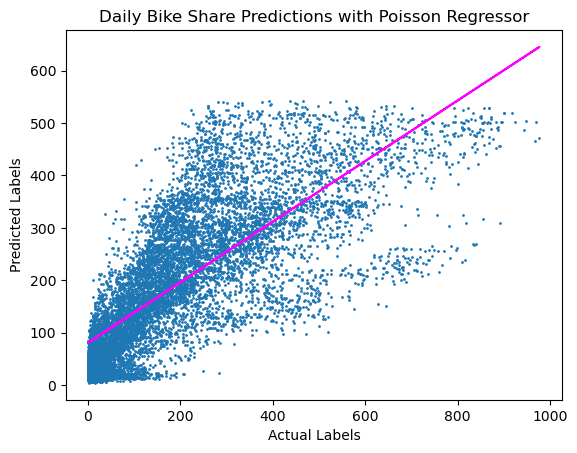

In [53]:
# Evaluate the model using the test data
predictions_poisson = pipe_poisson.predict(X)
mse = mean_squared_error(y, predictions_poisson)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y, predictions_poisson)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y, predictions_poisson, s=1)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions with Poisson Regressor')
# overlay the regression line
z = np.polyfit(y, predictions_poisson, 1)
p = np.poly1d(z)
plt.plot(y,p(y), color='magenta')
plt.show()


In [23]:
numerical_transform = Pipeline(
    [ ('scale', StandardScaler()),
      ('expand_features', PolynomialFeatures()) ] )

categorical_transform = Pipeline(
    [ ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore')) ] )

preprocessor = ColumnTransformer(
    [ ('transform_numeric', numerical_transform, numerical_features,),
      ('transform_categorical', categorical_transform, categorical_features) ],
      remainder='drop' )

pipe_lasso = Pipeline(
    [ ('transform_features', preprocessor),
      ('regressor', Lasso()) ] )

pipe_lasso.fit(X_train, y_train)

print("Coefficients:", pipe_lasso[1].coef_)
print("Intercept   :", pipe_lasso[1].intercept_)

print("train score :", pipe_lasso.score(X_train, y_train))
print("test score  :", pipe_lasso.score(X_test, y_test))

Coefficients: [  0.          51.23301397  41.98319039  20.91635201  67.10786114
  -0.89253641   6.445509     0.          24.47240318  -0.
   0.56781928  13.82527981  -0.           4.95769676 -70.52687354
   6.15719973 -26.75078855   0.          -0.           0.
 -14.36321861 -58.670709     0.        ]
Intercept   : 272.4137329060467
train score : 0.5174268058382512
test score  : 0.5099139213158703


MSE: 15894.934594117689
RMSE: 126.07511488837791
R2: 0.5155504480702405


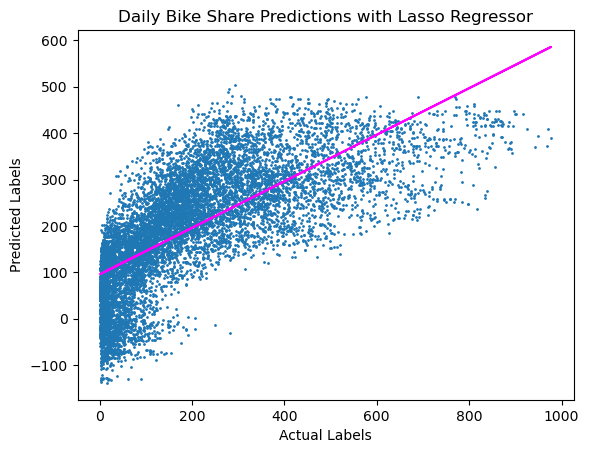

In [52]:
# Evaluate the model using the test data
predictions_lasso = pipe_lasso.predict(X)
mse = mean_squared_error(y, predictions_lasso)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y, predictions_lasso)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y, predictions_lasso, s=1)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions with Lasso Regressor')
# overlay the regression line
z = np.polyfit(y, predictions_lasso, 1)
p = np.poly1d(z)
plt.plot(y,p(y), color='magenta')
plt.show()


In [26]:
y_pred_lasso_2 = pipe_lasso.predict(X)
print(f'\nThe training RMSE: {np.sqrt(mean_squared_error(y,y_pred_lasso_2))}')
print(f'The training R2: {r2_score(y,y_pred_lasso_2)}')      
print(f'The training RMSLE: {np.sqrt(mean_squared_log_error(y, np.exp(y_pred_lasso_2)))}')


The training RMSE: 126.07511488837791
The training R2: 0.5155504480702405
The training RMSLE: 224.7945007627969


In [27]:
y_pred_poisson_2 = pipe_poisson.predict(X)
print(f'\nThe training RMSE: {np.sqrt(mean_squared_error(y,y_pred_poisson_2))}')
print(f'The training R2: {r2_score(y,y_pred_poisson_2)}')      
print(f'The training RMSLE: {np.sqrt(mean_squared_log_error(y, np.exp(y_pred_poisson_2)))}')


The training RMSE: 116.42140973778176
The training R2: 0.5868996898708814
The training RMSLE: 230.84967476727715


In [28]:
#pipe_poisson.get_params()

In [29]:
PARAM_GRID = PARAM_GRID = {
    'transform_features__transform_numeric__expand_features__degree': [2,3,4],
    'transform_features__transform_numeric__expand_features__interaction_only': [False, True],
    'regressor__alpha': [100, 10, 1, 0.1, 0.01],
    'regressor__max_iter': [5_000, 10_000, 20_000]
}

In [30]:
gscv = GridSearchCV(
    estimator = pipe_poisson,
    param_grid= PARAM_GRID,
    n_jobs = -1,
    cv = 5,
    verbose = 1
)

In [31]:
gscv.fit(X_train,y_train)
print(f'time taken: {round(gscv.refit_time_,2)} sec')

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evangelo/anaconda3/lib/python3.10/site-packages/sk

/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evangelo/anaconda3/lib/python3.10/site-packages/sk

/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evangelo/anaconda3/lib/python3.10/site-packages/sk

time taken: 1.63 sec


In [32]:
gscv.best_params_

{'regressor__alpha': 0.1,
 'regressor__max_iter': 5000,
 'transform_features__transform_numeric__expand_features__degree': 4,
 'transform_features__transform_numeric__expand_features__interaction_only': False}

In [33]:
gscv.best_score_

0.6486239572647906

In [34]:
best_model = gscv.best_estimator_
best_model.fit(X_train, y_train)
training_score = best_model.score(X_train, y_train)
validation_score = best_model.score(X_test, y_test)

print(f'Train score: {round(training_score, 6)}')
print(f'Validation score: {round(validation_score, 6)}')

Train score: 0.655937
Validation score: 0.641927


In [35]:
def my_scorer (y_true, y_pred, **kwargs):
    return mean_squared_log_error(y_true, y_pred, squared=False, **kwargs)

from sklearn.metrics import make_scorer

rmsle_scorer = make_scorer(my_scorer, greater_is_better = False)

print(rmsle_scorer(pipe_poisson, X_train, y_train))
print(rmsle_scorer(pipe_poisson, X_test, y_test))

-0.9613561196710413
-0.9607454205659159


In [36]:
from sklearn.ensemble import RandomForestRegressor

numerical_transform = Pipeline(
    [ ('scale', StandardScaler()),
      ('expand_features', PolynomialFeatures()) ] )

categorical_transform = Pipeline(
    [ ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore')) ] )

preprocessor = ColumnTransformer(
    [ ('transform_numeric', numerical_transform, numerical_features,),
      ('transform_categorical', categorical_transform, categorical_features) ],
      remainder='drop' )

pipe_rfg = Pipeline(
    [ ('transform_features', preprocessor),
      ('regressor', RandomForestRegressor()) ] )

pipe_rfg.fit(X_train, y_train)

print("train score :", pipe_rfg.score(X_train, y_train))
print("test score  :", pipe_rfg.score(X_test, y_test))

train score : 0.9856340457396269
test score  : 0.927071662986076


MSE: 951.8542440018892
RMSE: 30.852135161150343
R2: 0.9709891626619335


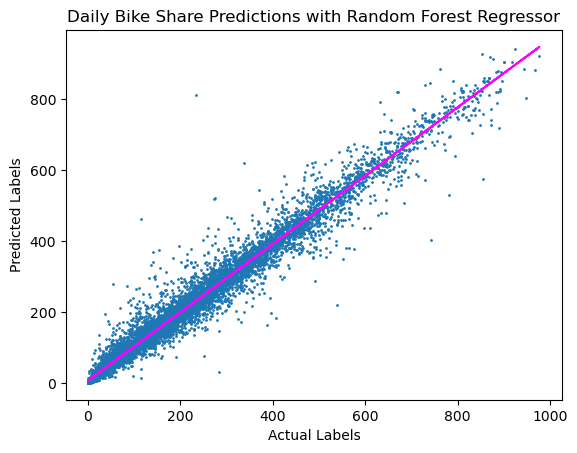

In [64]:
# Evaluate the model using the test data
predictions = pipe_rfg.predict(X)
mse = mean_squared_error(y, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y, predictions, s=1)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions with Random Forest Regressor')
# overlay the regression line
z = np.polyfit(y, predictions, 1)
p = np.poly1d(z)
plt.plot(y,p(y), color='magenta')
plt.show()


MSE: 2393.073374883405
RMSE: 48.91904920256939
R2: 0.927071662986076


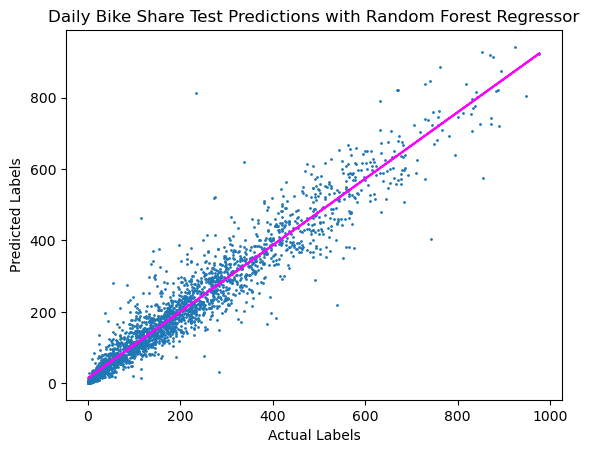

In [60]:
# Evaluate the model using the test data
predictions_rfg_test = pipe_rfg.predict(X_test)
mse = mean_squared_error(y_test, predictions_rfg_test)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions_rfg_test)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions_rfg_test, s=1)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Test Predictions with Random Forest Regressor')
# overlay the regression line
z = np.polyfit(y_test, predictions_rfg_test, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()


In [46]:
gscv_rfg = GridSearchCV(
    estimator = pipe_rfg,
    param_grid= PARAM_GRID_rfg,
    n_jobs = -1,
    cv = 5,
    verbose = 1
)

In [44]:
PARAM_GRID_rfg = {'transform_features__transform_numeric__expand_features__degree': [2, 3, 4],
 'transform_features__transform_numeric__expand_features__interaction_only': [False,
  True]}
 #'regressor__alpha': [100, 10, 1],
 #'regressor__max_iter': [5000, 10000, 20000]}

In [48]:
gscv_rfg.fit(X_train,y_train)
print(f'time taken: {round(gscv_rfg.refit_time_,2)} sec')

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evangelo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evangelo/anaconda3/lib/python3.10/site-packages/sk

time taken: 3.04 sec


In [49]:
gscv_rfg.best_params_, gscv_rfg.best_score_

({'transform_features__transform_numeric__expand_features__degree': 2,
  'transform_features__transform_numeric__expand_features__interaction_only': False},
 0.9194497872883793)

In [50]:
best_model_rfg = gscv_rfg.best_estimator_
best_model_rfg.fit(X_train, y_train)
training_score_rfg = best_model_rfg.score(X_train, y_train)
validation_score_rfg = best_model_rfg.score(X_test, y_test)

print(f'Train score: {round(training_score_rfg, 6)}')
print(f'Validation score: {round(validation_score_rfg, 6)}')

Train score: 0.985512
Validation score: 0.92668


MSE: 958.0739756270914
RMSE: 30.95277008002824
R2: 0.9707995962197999


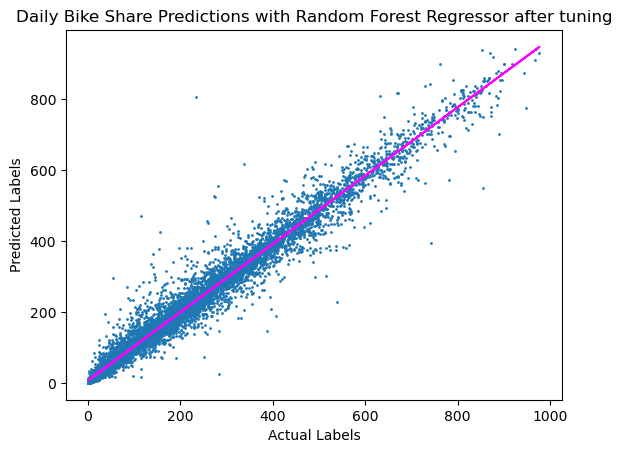

In [62]:
# Evaluate the model using the test data
predictions_best_model_rfg = best_model_rfg.predict(X)
mse = mean_squared_error(y, predictions_best_model_rfg)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y, predictions_best_model_rfg)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y, predictions_best_model_rfg, s=1)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions with Random Forest Regressor after tuning')
# overlay the regression line
z = np.polyfit(y, predictions_best_model_rfg, 1)
p = np.poly1d(z)
plt.plot(y,p(y), color='magenta')
plt.show()

In [55]:
def my_scorer (y_true, y_pred, **kwargs):
    return mean_squared_log_error(y_true, y_pred, squared=False, **kwargs)

from sklearn.metrics import make_scorer

rmsle_scorer = make_scorer(my_scorer, greater_is_better = False)

print(rmsle_scorer(pipe_rfg, X_train, y_train))
print(rmsle_scorer(pipe_rfg, X_test, y_test))

-0.1876092607099743
-0.3497305846983991
